In [ ]:
# Based on "Stock Price Prediction & Forecasting with LSTM Neural Networks in Python" By Greg Hogg

In [1]:
import pandas as pd

In [45]:
df = pd.read_csv('MSFT.csv')

In [46]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060980,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063158,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064247,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062613,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061524,47894400


In [47]:
df = df[['Date', 'Close']]

In [48]:
df.head()

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090


In [49]:
import datetime

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

print(str_to_datetime('1986-03-19'))

1986-03-19 00:00:00


In [50]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9219   2022-10-10
9220   2022-10-11
9221   2022-10-12
9222   2022-10-13
9223   2022-10-14
Name: Date, Length: 9224, dtype: datetime64[ns]

In [51]:
df.index = df.pop('Date')

In [52]:
df.head()

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090


In [53]:
import matplotlib.pyplot as plt

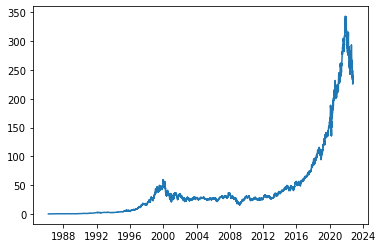

In [54]:
plt.plot(df.index, df['Close'])

In [55]:
from matplotlib import dates
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
    
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
        
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        if last_time:
            break
        
        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
    
    ret_df['Target'] = Y

    return ret_df

windowed_df = df_to_windowed_df(df, '2021-03-25', '2022-03-23', n=3)
windowed_df.head()

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004


In [56]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]

    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

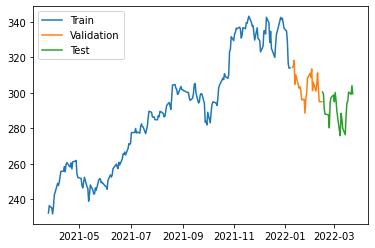

In [57]:
q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [59]:
model = Sequential([layers.Input((3, 1)),
layers.LSTM(64),
layers.Dense(32, activation='relu'),
layers.Dense(32, activation='relu'),
layers.Dense(1)])

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 1s 49ms/step - loss: 84466.9766 - mean_absolute_error: 288.8863 - val_loss: 91995.0234 - val_mean_absolute_error: 303.2195
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 83992.8594 - mean_absolute_error: 288.0699 - val_loss: 91492.8984 - val_mean_absolute_error: 302.3904
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 83495.8984 - mean_absolute_error: 287.2065 - val_loss: 90917.9531 - val_mean_absolute_error: 301.4382
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 82895.3359 - mean_absolute_error: 286.1535 - val_loss: 90172.4219 - val_mean_absolute_error: 300.1989
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 82095.8672 - mean_absolute_error: 284.7533 - val_loss: 89194.4609 - val_mean_absolute_error: 298.5657
Epoch 6/100
7/7 [==============================] - 0s 5ms/step - loss: 81093.4219 - mean_absolute_error: 282.9842 - val_loss: 87950.67

7/7 [==============================] - 0s 1ms/step


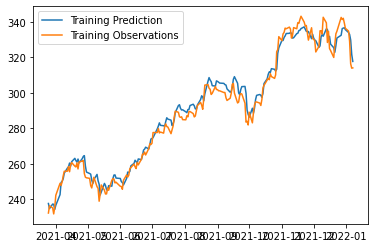

In [60]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Prediction', 'Training Observations'])

1/1 [==============================] - 0s 15ms/step


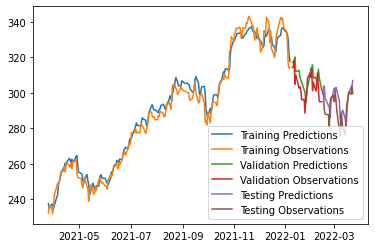

In [61]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, model.predict(X_val).flatten())
plt.plot(dates_val, y_val)
plt.plot(dates_test, model.predict(X_test).flatten())
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 'Training Observations', 'Validation Predictions', 'Validation Observations',
'Testing Predictions', 'Testing Observations'])

In [62]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
    last_window = deepcopy(X_train[-1])
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window[-1] = next_prediction

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step


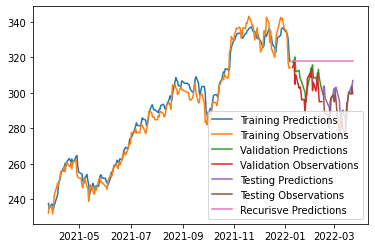

In [63]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, model.predict(X_val).flatten())
plt.plot(dates_val, y_val)
plt.plot(dates_test, model.predict(X_test).flatten())
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 'Training Observations', 'Validation Predictions', 'Validation Observations',
'Testing Predictions', 'Testing Observations', 'Recurisve Predictions'])